In [68]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys, os
sys.path.append('../smc')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [69]:
import numpy as np   
import pandas as pd
import pdb
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from tqdm import tqdm
import sys

In [70]:
from utils import *     # contains some useful helper functions 
from models import *    # toy models
from solvers import *   # matrix completion solvers
from methods import *

In [72]:
# Matrix shape and rank
n1, n2 = 200, 200
k = 6
r = 4
prop_obs = 0.2
random_state = 0
allow_inf = False
alpha = 0.1

In [95]:
max_test_queries = 500
bias_scale = 0.5
sampler = QuerySampling(n1,n2)
bias = SamplingBias(n1,n2)
# Sample test queries with weights
w = bias.inc_weights(scale = bias_scale)

# Split observation mask uniformly
mask_obs, mask_test = sampler.sample_submask(sub_size=prop_obs, w=w, random_state=random_state)


n_test_queries = min(np.sum(np.sum(mask_test, axis=1) // k), max_test_queries)
_, idxs_test, _ = sampler.sample_train_calib(mask_test, k, calib_size=n_test_queries, random_state=random_state)

In [96]:
# Generate a random true matrix 
RFM = RandomFactorizationModel(n1 ,n2, r)
U, V, M = RFM.sample_noiseless(random_state)

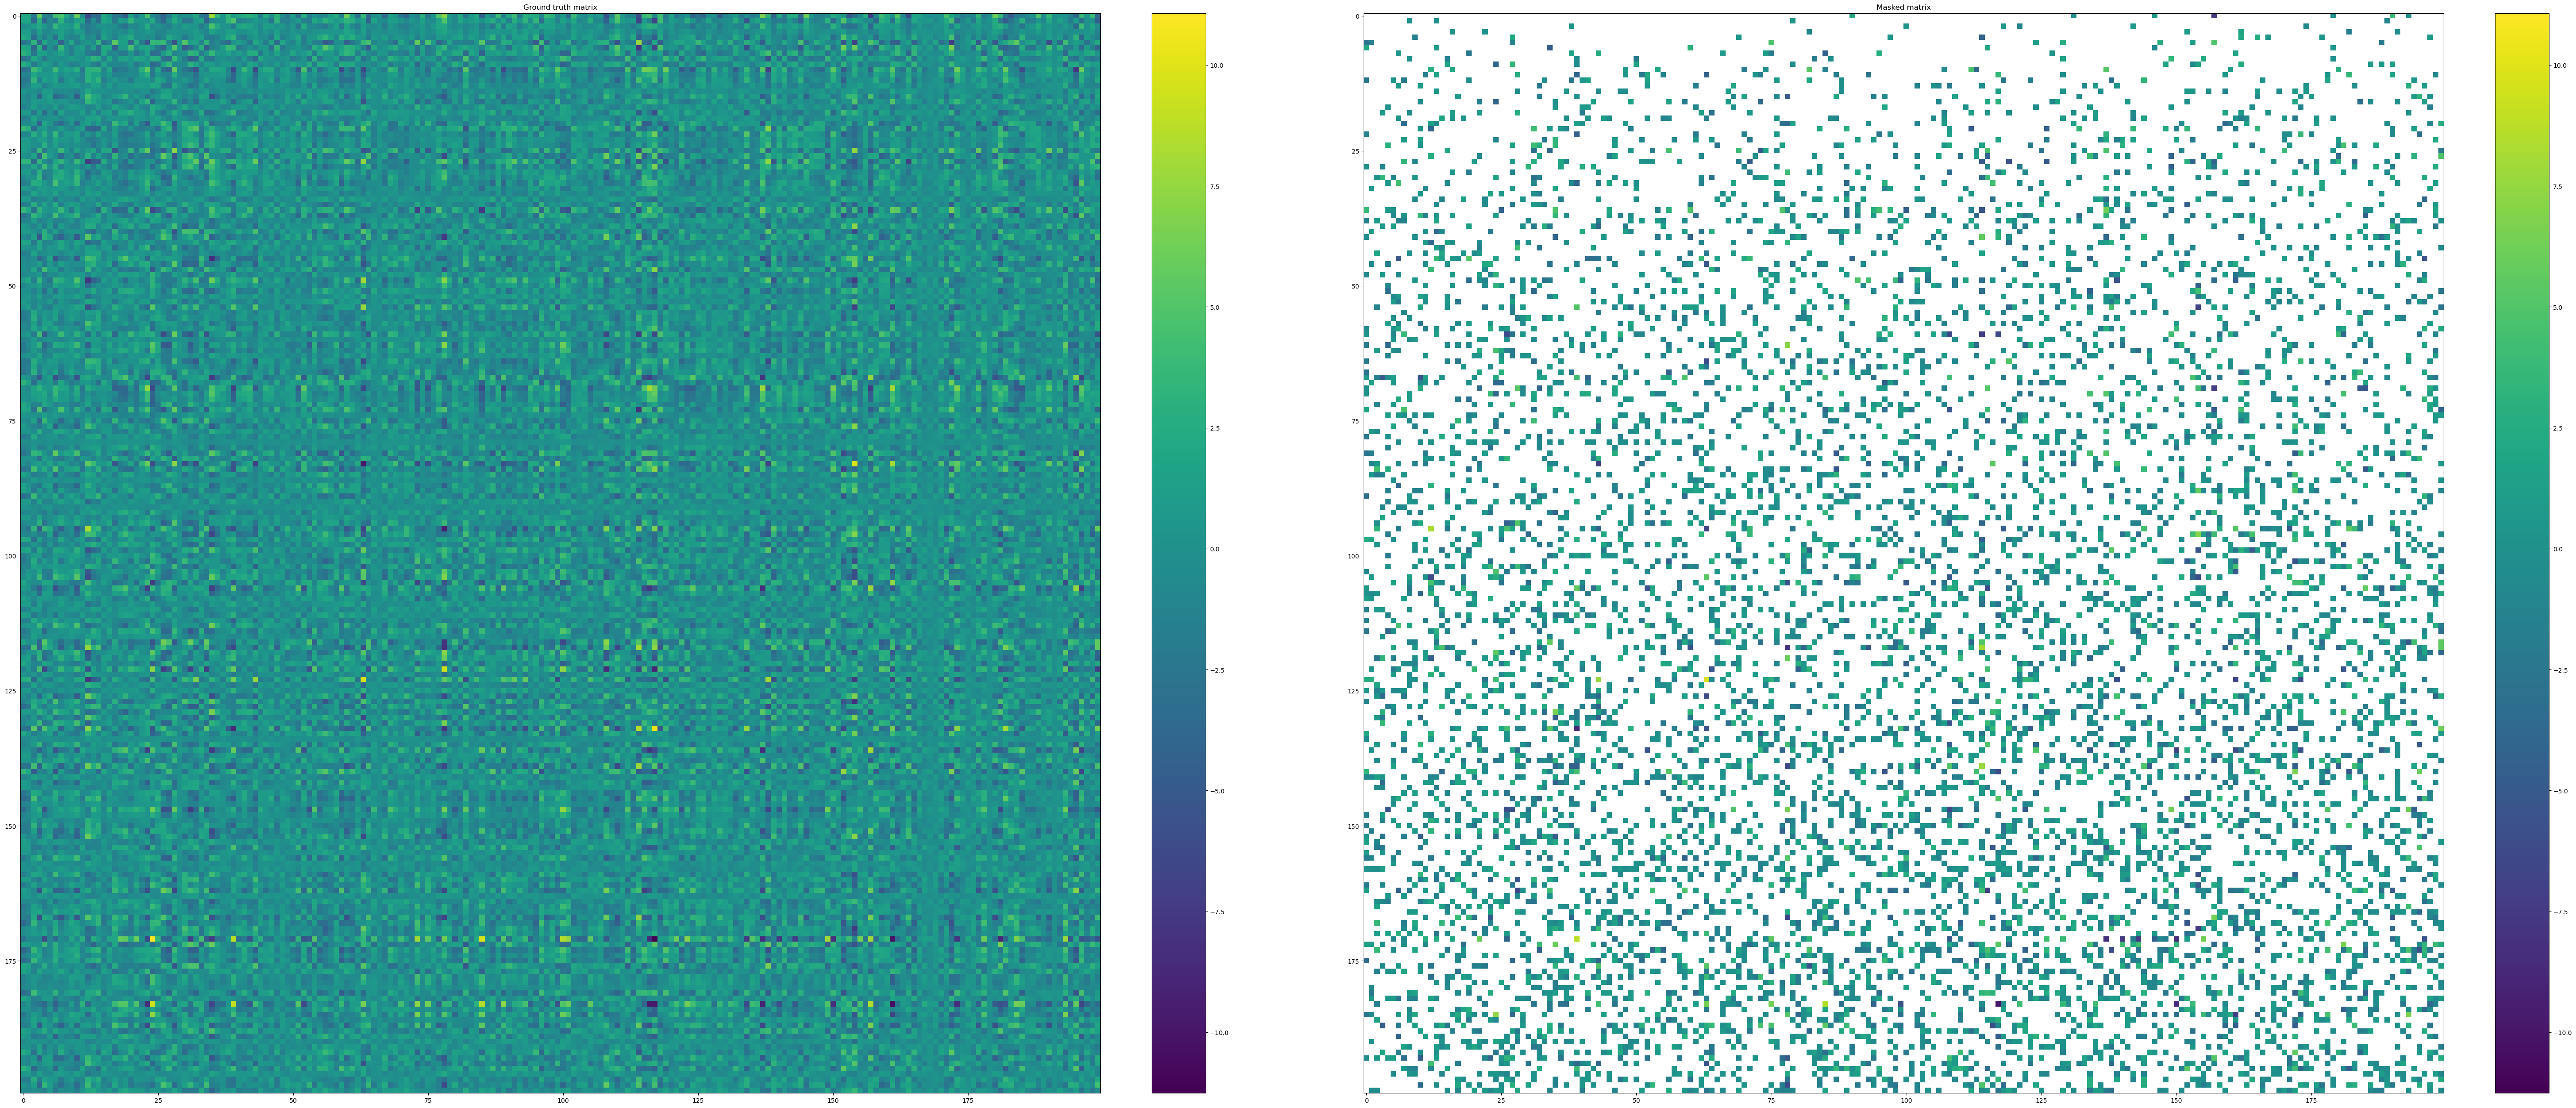

Missing entries are masked in white.


In [97]:
plot_before_after_mask(M, mask_obs, bad_color="white", figsize=(60,25))
print("Missing entries are masked in white.")

# Simultaneous Conformal Inference

In [98]:
max_calib_queries = 1000
n_calib_queries = min(int(0.5 * np.sum(np.sum(mask_obs, axis=1) // k)), max_calib_queries)
mask_train, idxs_calib, mask_calib = sampler.sample_train_calib(mask_obs, k, 
                                        calib_size=n_calib_queries, random_state=random_state)

print("Observation size: {}, training size: {},  calib queries: {}, test queries: {}"
      .format(np.sum(mask_obs), np.sum(mask_train), int(np.sum(mask_calib)//k), len(idxs_test[0])//k))

Observation size: 8000, training size: 4244,  calib queries: 626, test queries: 500


In [99]:
# Train matrix completion model
Mhat, _, _ = pmf_solve(M, mask_train, k=r, random_state=random_state)

Iteration: 1; Mean diff: 0.0015
Iteration: 2; Mean diff: 0.0000
Iteration: 3; Mean diff: 0.0000
Iteration: 4; Mean diff: 0.0000
Iteration: 5; Mean diff: 0.0000
Iteration: 6; Mean diff: 0.0000
Iteration: 7; Mean diff: 0.0000
Stopping criteria met, training terminated.


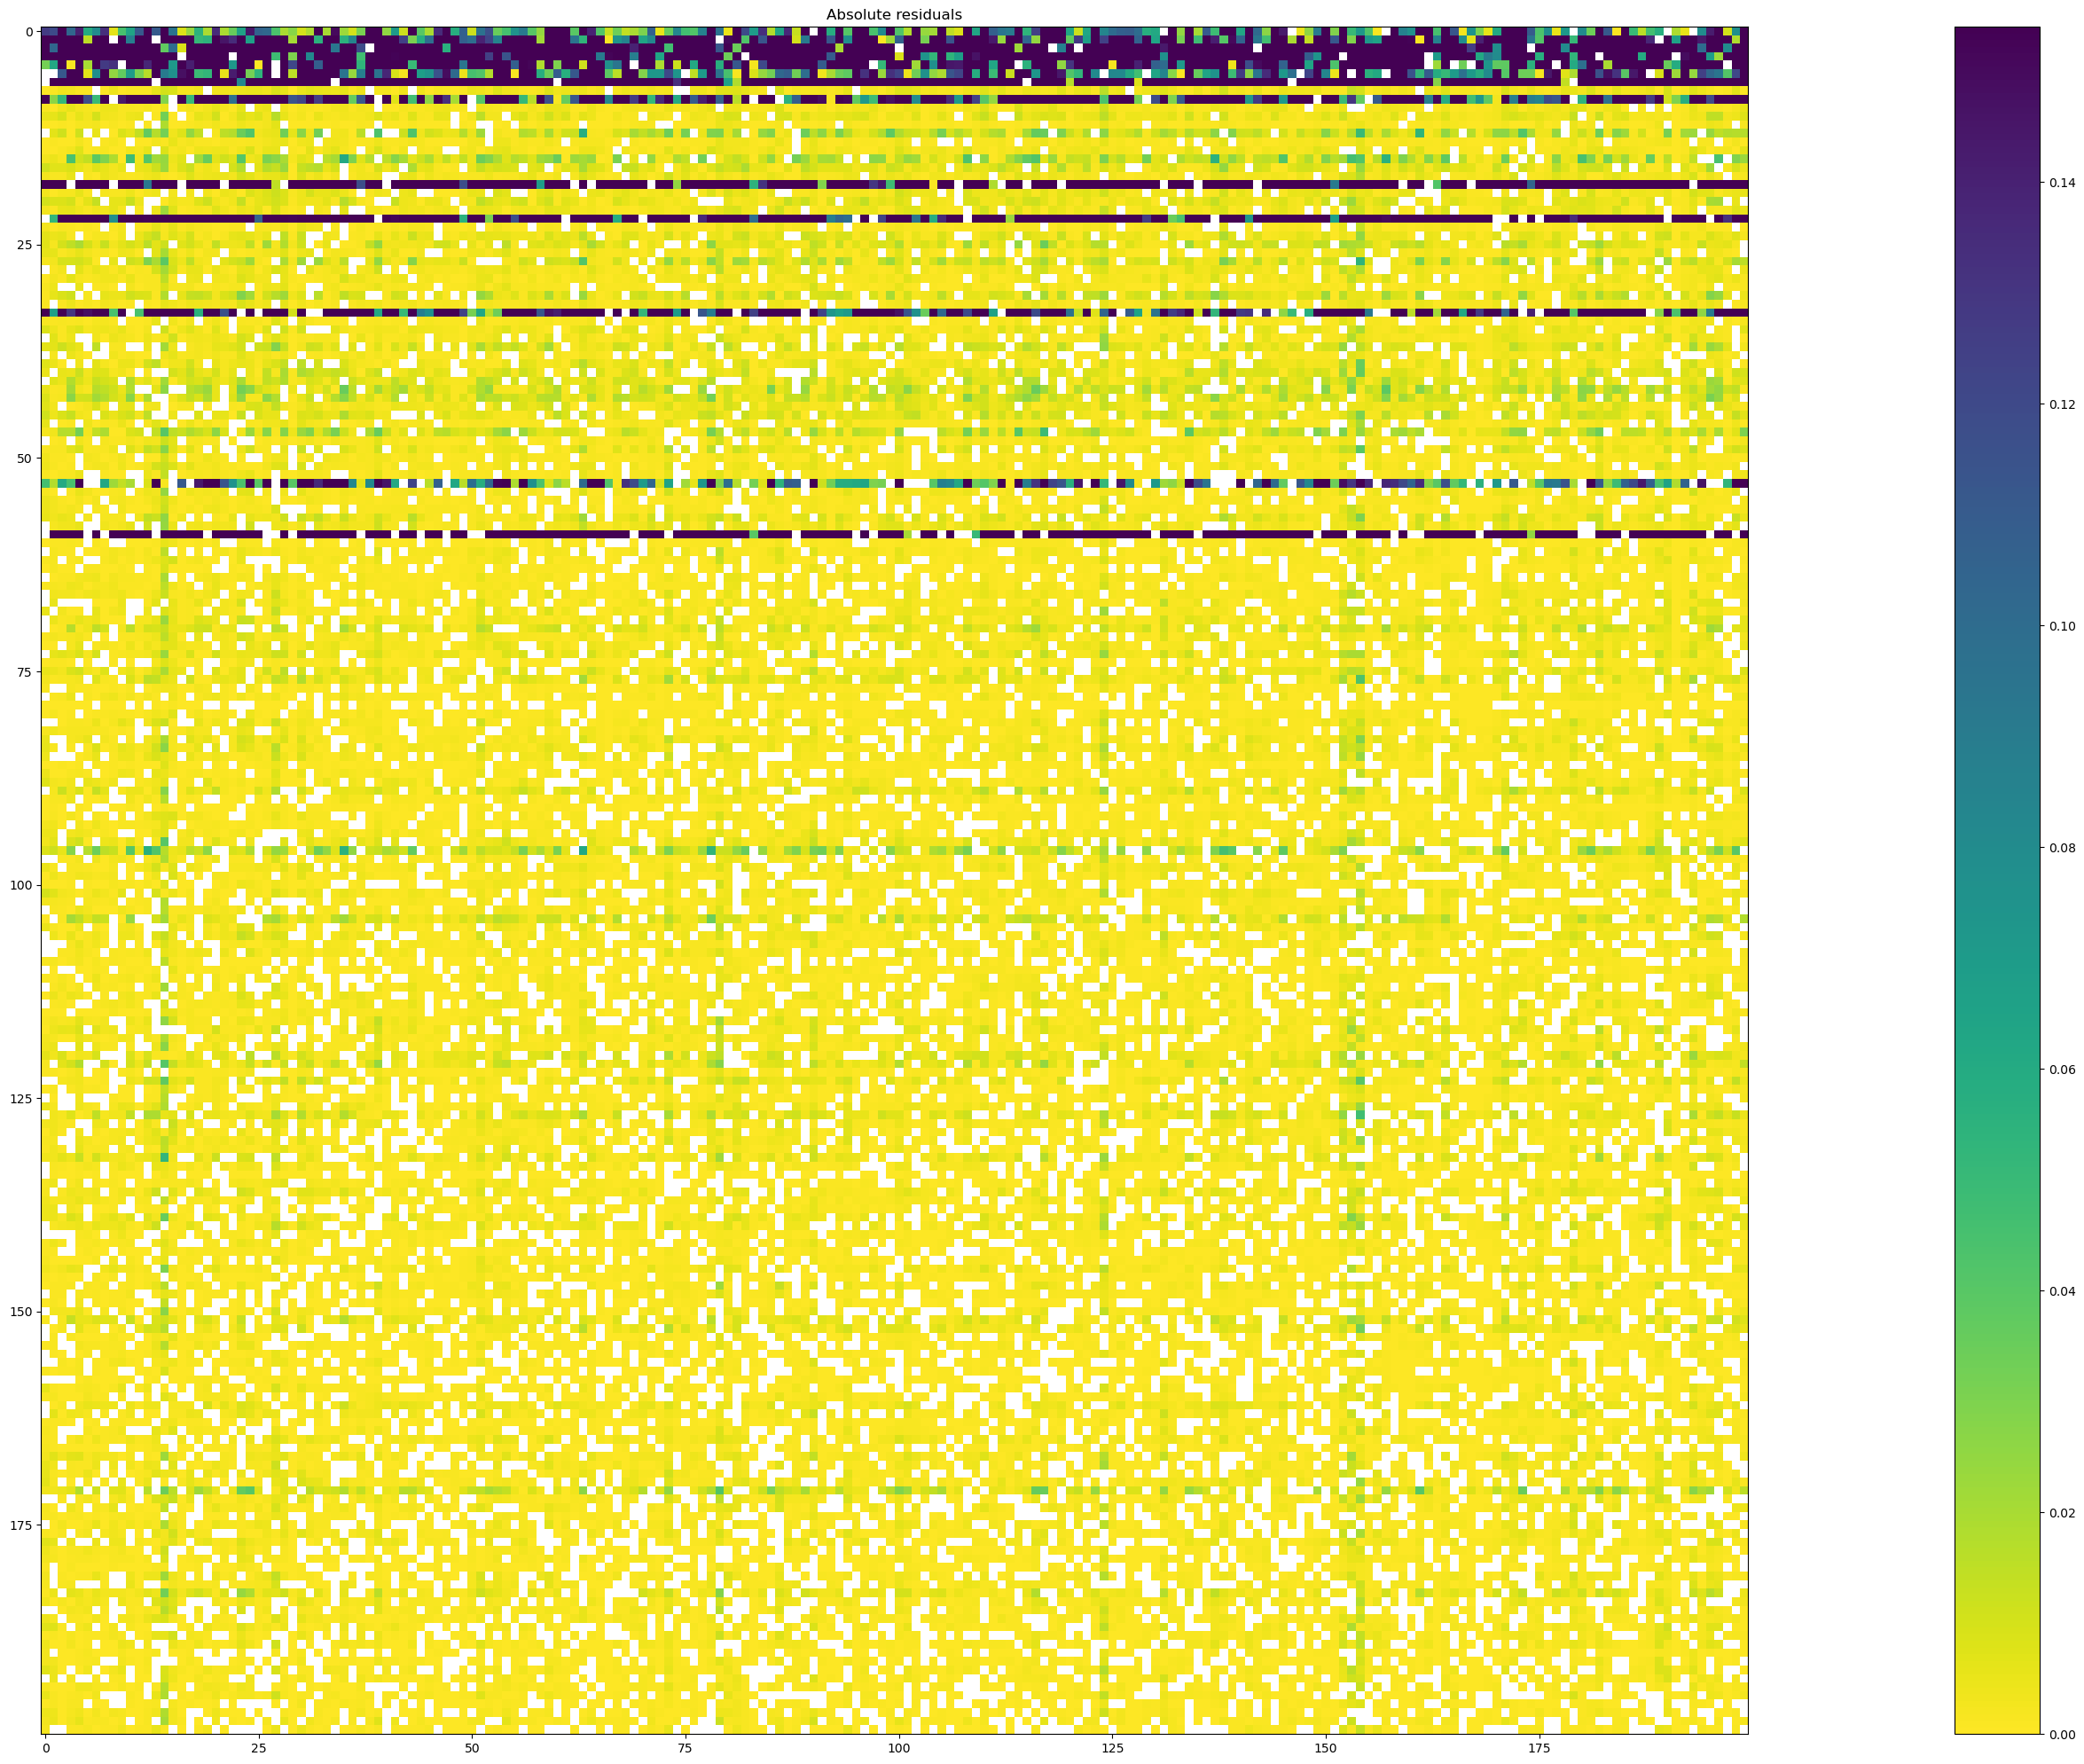

In [100]:
error_heatmap(M, Mhat, mask_test, figsize=(60,25))

In [101]:
ci_method = SimulCI(M, Mhat, mask_obs, idxs_calib, k, w_obs=w)
df = ci_method.get_CI(idxs_test, alpha, allow_inf=allow_inf)
lower, upper, is_inf= df.loc[0].lower, df.loc[0].upper, df.loc[0].is_inf
res = evaluate_SCI(lower, upper, k, M, idxs_test, is_inf=is_inf, method="SMC")

Computing conformal prediction intervals for 500 test queries...


CI: 100%|████████████████████████████████████████████████████████████████████████████| 500/500 [00:13<00:00, 37.84it/s]

Done!


In [102]:
res

,Query_coverage,Coverage,Size,Inf_prop,Method
0,0.854,0.905,0.120921,0.006,SMC


# Bonferroni benchmark

In [103]:
mask_train, idxs_calib, mask_calib = sampler.sample_train_calib(mask_obs, 1, 
                                        calib_size=n_calib_queries*k, random_state=random_state)

print("Observation size: {}, training size: {}, calib size: {}, test queries: {}"
      .format(np.sum(mask_obs), np.sum(mask_train), np.sum(mask_calib), len(idxs_test[0])//k))

Observation size: 8000, training size: 4244, calib size: 3756, test queries: 500


In [104]:
# Train matrix completion model
Mhat, _, _ = pmf_solve(M, mask_train, k=r, random_state=random_state)

Iteration: 1; Mean diff: 0.0005
Iteration: 2; Mean diff: 0.0000
Iteration: 3; Mean diff: 0.0000
Iteration: 4; Mean diff: 0.0000
Iteration: 5; Mean diff: 0.0000
Iteration: 6; Mean diff: 0.0000
Iteration: 7; Mean diff: 0.0000
Stopping criteria met, training terminated.


In [106]:
a_list = [alpha, alpha * k]
ci_method = Bonf_benchmark(M, Mhat, mask_obs, idxs_calib, k, w_obs=w)
df = ci_method.get_CI(idxs_test, a_list, allow_inf=allow_inf)
for i, m in enumerate(["Bonferroni", "Uncorrected"]):
    lower, upper, is_inf= df.loc[i].lower, df.loc[i].upper, df.loc[i].is_inf
    res = pd.concat([res, evaluate_SCI(lower, upper, k, M, idxs_test, is_inf=is_inf, method=m)])

Computing Bonferroni-style intervals for 500 test queries...


CI: 100%|██████████████████████████████████████████████████████████████████████████| 3000/3000 [05:51<00:00,  8.52it/s]

Done!


In [108]:
res

,Query_coverage,Coverage,Size,Inf_prop,Method
0,0.854,0.905000,0.120921,0.006,SMC
0,0.954,0.969000,0.155134,0.002,Uncorrected
0,0.716,0.890333,0.016756,0.000,Bonferroni


In [107]:
np.mean(is_inf)*k

0.0

In [109]:
df

,alpha,lower,upper,is_inf
0,0.1,"[1.4135172190226117, -2.155302590148043, -2.34...","[1.565263228242518, -2.0035565809281373, -2.19...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,0.6,"[1.4810157723631858, -2.0878040368074693, -2.2...","[1.497764674901944, -2.071055134268711, -2.259...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [112]:
np.mean(df.loc[0].is_inf)*k

0.002

In [113]:
k

6